# PIE - High level features for audio classification

In this notebook, we will go through specific high level features that allow ".wav" files to be interpreted by machine learning algorithms. Upon creating new specific features from our raw data, we will try to give some visual insights on their relevancy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import os.path as osp

datapath = "../../data_pie/"
#datapath = "../../data/" ##The datapath depends on the configuration of your own folder PIE. Check your data path out !


train = pd.read_csv(datapath + "data-PIE-Sonar.csv")
list_labels = train.label.unique()


## Some useful functions to explore with librosa

In [2]:
def display_rand():
    #i = int( np.random.rand() * train['fname'].count() )
    i = 2
    print("Train sample #"+str(i) + "\nLabel : " + train['label'][i])
    data,sample_rate = librosa.load(datapath + "audio_train/" + train['fname'][i])
    plt.figure(figsize=(12,4))
    librosa.display.waveplot(data,sr=sample_rate)

In [3]:
##How to get the duration of a given file with its name ?

filename = "00044347.wav"
data,sample_rate = librosa.load(datapath + "audio_train/" + filename)

duration = librosa.core.get_duration(data)

print("Duration of the file : " + filename + "\n" + str(duration) + " sc")


Duration of the file : 00044347.wav
14.0 sc


How to derive the autocorrelation of a given audio file ? The analysis of autocorrelation is a mathematical tool for finding repeating patterns, such as the presence of a periodic signal obscured by noise, or identifying the missing fundamental frequency in a signal implied by its harmonic frequencies

/Users/etiennedupont/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


[3.2235565e+02 3.1156375e+02 3.0153329e+02 ... 2.0542093e-06 2.0135039e-06
 2.0033478e-06]


Text(0.5,0,'Lag (frames)')

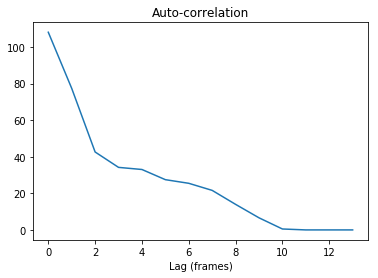

In [4]:
filename = "0a2a5c05.wav" #CAREFUL ! The following lines are way to long to compute for signals lasting more than a few
data,sample_rate = librosa.load(datapath + "audio_train/" + filename) #seconds ! Hence the very short file here.

print(librosa.autocorrelate(data))

odf = librosa.onset.onset_strength(y=data, sr=sample_rate, hop_length=512)
ac = librosa.autocorrelate(odf, max_size=4* sample_rate / 512)
plt.plot(ac)
plt.title('Auto-correlation')
plt.xlabel('Lag (frames)')

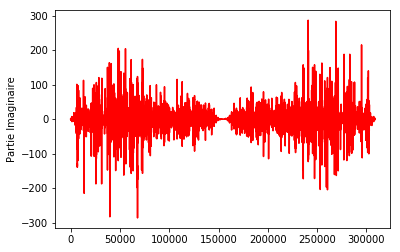

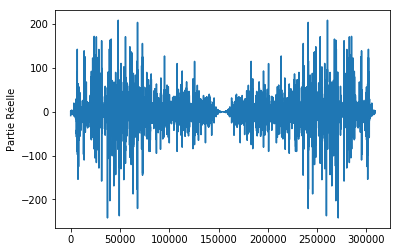

In [5]:
###How to compute the Discrete Fourier Transform of a signal using the Fast Fourier Transform (FFT) ?

filename = "00044347.wav"
data,sample_rate = librosa.load(datapath + "audio_train/" + filename)

a = np.fft.fft(data)

plt.plot(np.imag(a), color = 'r')
plt.ylabel("Partie Imaginaire")
plt.show()

plt.plot(np.real(a))
plt.ylabel("Partie Réelle")
plt.show()

[ 1.1424987e-06-1.2919951e-06j -9.5491214e-07-3.3187234e-06j
 -2.2657777e-07-5.1912475e-06j ...  1.2311801e-08-2.7966962e-09j
  1.4272075e-08-2.6993803e-09j  1.5585897e-08-1.7358843e-09j]


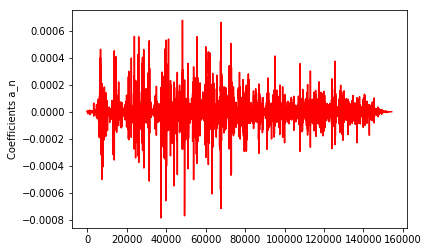

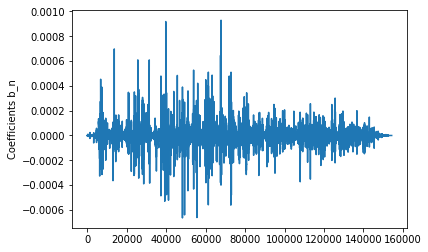

In [6]:
###How to compute the Discrete Inverse Fourier Transform of a signal using the Fast Fourier Transform (IFFT) ?

filename = "00044347.wav"
data,sample_rate = librosa.load(datapath + "audio_train/" + filename)

a = np.fft.ifft(data)
n = len(a)
a = a[1:n//2] ##should contain the positive-frequency terms

print(a)

plt.plot(np.real(a), color = 'r')
plt.ylabel("Coefficients a_n")
plt.show()

plt.plot(np.imag(a))
plt.ylabel("Coefficients b_n")
plt.show()

## We can therefore figure out more easily which frequencies are favoured and which are neglectable

## 1 - MFCC

Here we are going to output and visualize MFCC features of our data. The Mel-frequency cepstrum proved efficient in speech recognition systems and music information retrieval. It combines some mathematical manipulation like Fourier transform with the mel scale which is a human-shaped scale to separate pitches. It is said to be quite sensitive to noise. Engineers often filter low-energy frequencies to avoid inaccuracies with MFCC.

source: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

### Feature extraction

In [7]:
def parser_mfcc(row):
    file_name = osp.join(datapath,"audio_train/",row['fname'])
    try:
        # here kaiser_fast is a technique used for faster extraction
        X,sample_rate = librosa.load(file_name,res_type='kaiser_fast')
        # we extract mfcc feature from data
        #Below, we choose to breakdown the spectrum into n_mfcc variables
        mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=20).T,axis=0)
    except Exception as e:
        print('Error encountered while parsing the file:',file_name)  
        return 'None'
    feature = mfccs  
    return pd.Series([feature])

def parser_mfcc_raw(audio_file, sample_rate, n_mfcc): 
    # Here we extract mfcc feature from data
    # n_mfcc is the length of the output array : 
    # we choose to breakdown the spectrum into n_mfcc variables
    mfccs = np.mean(librosa.feature.mfcc(y=audio_file,sr=sample_rate,n_mfcc=n_mfcc).T,axis=0)
    return pd.Series([feature])

def add_mfcc_features(data):
    res = data.assign(mfcc_features=data.apply(parser_mfcc,axis=1))
    return res

Let's input those new features into the original dataframe

In [8]:
temp = train[train['manually_verified']==1]
temp = add_mfcc_features(train)
temp.head(5)

,fname,label,manually_verified,mfcc_features
0,00044347.wav,Hi-hat,0,"[-427.5374365640695, 18.41126230792658, -50.83..."
1,001ca53d.wav,Saxophone,1,"[-338.268402343742, 90.41933851558248, -62.314..."
2,002d256b.wav,Trumpet,0,"[-624.4203610189654, 105.8256752836188, 1.3321..."
3,0033e230.wav,Glockenspiel,1,"[-764.5293831437475, 8.71873262770302, -6.4384..."
4,00353774.wav,Cello,1,"[-317.2021146724346, 94.64278975980076, -29.87..."


### Visualization 

Now we extract the features 

In [9]:
from sklearn.preprocessing import LabelEncoder

temp = temp[temp['mfcc_features']!='None'] #We get rid of missing data
X = np.array(temp.mfcc_features.tolist())
y = np.array(temp.label.tolist())

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) #switch from string categories to int categories

/Users/etiennedupont/anaconda3/lib/python3.6/site-packages/pandas/core/ops.py:1122: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x, y, op)


Explained variance (%): [79.76348831  9.48818282]


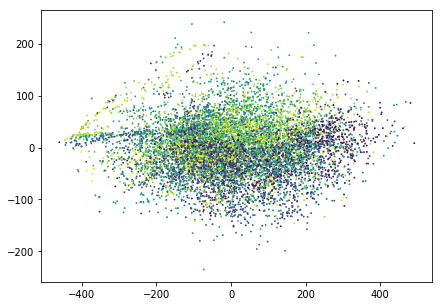

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
Xpca = pca.fit_transform(X)
print("Explained variance (%): "+ str(pca.explained_variance_ratio_*100))

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(Xpca[:, 0], Xpca[:, 1], s=.7,c=y_encoded)

It is a mess... seems complex to manipulate 41 classes! Let's compare some classes we expect to be different.

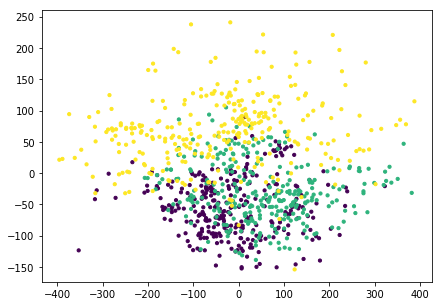

In [11]:
def idx_groups(l):
    idx = []
    for s in l:
        idx += list(np.where(y == s)[0])
    return idx

idx_y = idx_groups(['Cello','Fireworks','Hi-hat'])


fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(Xpca[idx_y, 0], Xpca[idx_y, 1], s=10,c=y_encoded[idx_y])

Not really convincing anyway.

Another idea would be to compare each group's mean in this plot.

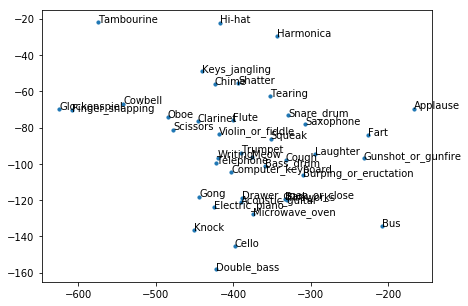

In [12]:
means_mfcc = []
x_mean = []
y_mean = []
comp1 = pca.components_[0]
comp2 = pca.components_[1]

for s in list_labels:
    s_data = temp[temp['label'] == s]
    mfcc_ft = s_data.mfcc_features
    mfcc_mean = np.array([0.]*20)
    n = np.shape(mfcc_ft)[0]
    for i in mfcc_ft.index:
        mfcc_mean += mfcc_ft[i] / n
    means_mfcc.append(mfcc_mean)
    x_mean.append(np.dot(comp1,mfcc_mean))
    y_mean.append(np.dot(comp2,mfcc_mean))

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x_mean, y_mean, s=10)
for i in range(41):
    plt.annotate(list_labels[i], (x_mean[i],y_mean[i]))

This becomes more interresting! Let's focus on the 'center'

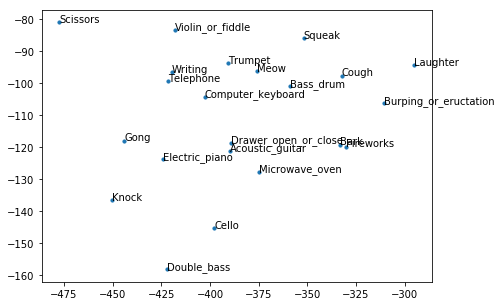

In [13]:
x_mean = np.array(x_mean)
y_mean = np.array(y_mean)

idx = list(set(np.where(x_mean<-280)[0])
          .intersection(set(np.where(x_mean>-480)[0]))
          .intersection(set(np.where(y_mean<-80)[0])))

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x_mean[idx], y_mean[idx], s=10)
for i in idx:
    plt.annotate(list_labels[i], (x_mean[i],y_mean[i]))

## Some insights about the importance of samples length

In [ ]:
#another feature will be useful later: audio length
def parser_length(row):   
    y, sr = librosa.load(datapath+"audio_train/"+row['fname'])
    len_audio = len(y) * 1/sr
    return len_audio

def add_length(data):
    res = data.assign(audio_length=data.apply(parser_length,axis=1))
    return res

temp = add_length(temp)

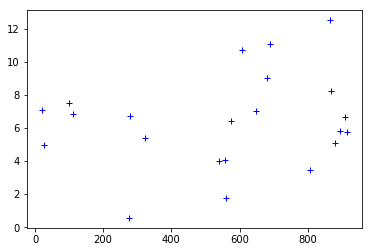

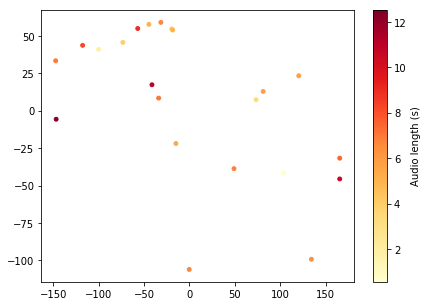

In [18]:
idx_y = idx_groups(['Flute'])
idx_all = idx_groups(list_labels)

#try
#idx_y = idx_all

vec_length = temp['audio_length'][idx_y]

plt.plot(vec_length,'b+')
plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
s = ax.scatter(Xpca[idx_y, 0], Xpca[idx_y, 1], s=15,c=vec_length,cmap="YlOrRd")
fig.colorbar(s, label='Audio length (s)')

At first sight, we can't see evident correlation between coordinates in PCA and length of the audio file...